In [1]:
# Imports and environment setup
import os
import glob
import random
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


Total number of audio clips: 360573
Sample file: data/100_all/preprocessed_audio/20121212-0900-PLENARY-12_en_seg95.wav
Waveform shape: torch.Size([1, 16000])
Sample rate: 16000


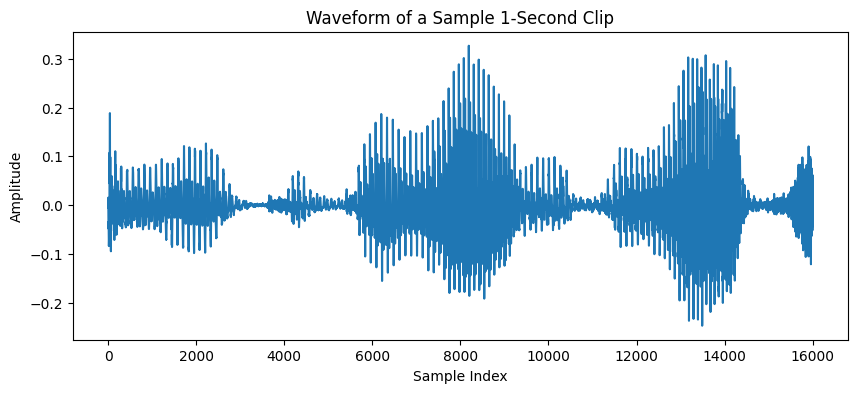

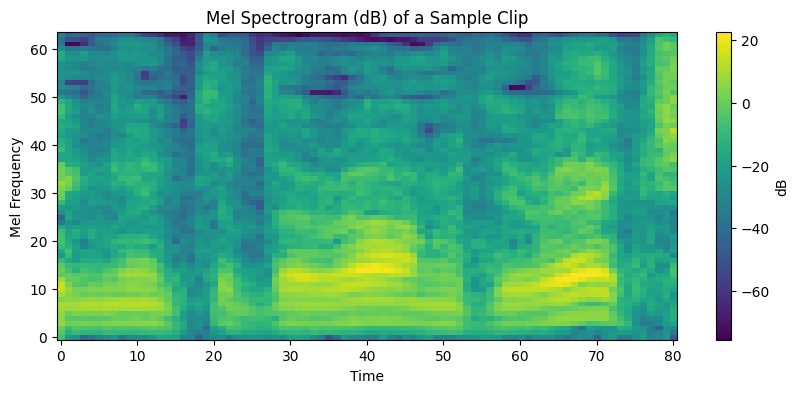

In [2]:

dataset_dir = "data/100_all"

filepaths = glob.glob(os.path.join(dataset_dir, '**', '*.wav'), recursive=True)
print("Total number of audio clips:", len(filepaths))


sample_path = filepaths[0]
waveform, sr = torchaudio.load(sample_path)
print("Sample file:", sample_path)
print("Waveform shape:", waveform.shape)  
print("Sample rate:", sr)

# Plot the waveform of the sample file
plt.figure(figsize=(10, 4))
plt.plot(waveform.squeeze().numpy())
plt.title("Waveform of a Sample 1-Second Clip")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()


mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_mels=64)
spec = mel_transform(waveform)
spec_db = torchaudio.transforms.AmplitudeToDB()(spec)

plt.figure(figsize=(10, 4))
plt.imshow(spec_db.squeeze().numpy(), origin="lower", aspect="auto", cmap="viridis")
plt.title("Mel Spectrogram (dB) of a Sample Clip")
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.colorbar(label="dB")
plt.show()


In [3]:


class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.filepaths = glob.glob(os.path.join(root_dir, '**', '*.wav'), recursive=True)
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        waveform, sample_rate = torchaudio.load(filepath)
        if self.transform:
            waveform = self.transform(waveform)
        return waveform, sample_rate


audio_dataset = AudioDataset(dataset_dir)
print("Total number of audio clips in dataset:", len(audio_dataset))


dataset_size = len(audio_dataset)
train_size   = int(0.8 * dataset_size)  
val_size     = int(0.1 * dataset_size)  
test_size    = dataset_size - train_size - val_size  

train_dataset, val_dataset, test_dataset = random_split(
    audio_dataset, [train_size, val_size, test_size]
)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=16)
val_dataloader   = DataLoader(val_dataset,   batch_size=128, shuffle=False, num_workers=16)
test_dataloader  = DataLoader(test_dataset,  batch_size=128, shuffle=False, num_workers=16)


Total number of audio clips in dataset: 360573
Training set size: 288458
Validation set size: 36057
Test set size: 36058


In [4]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

def compute_all_metrics(pred_probs, target, threshold=0.5):
    pred_flat = pred_probs.view(-1).detach().cpu().numpy()
    target_flat = target.view(-1).detach().cpu().numpy()
    
    pred_labels = (pred_flat >= threshold).astype(int)
    target_labels = target_flat.astype(int)
    
    acc = accuracy_score(target_labels, pred_labels)
    roc_auc = roc_auc_score(target_labels, pred_flat)
    precision = precision_score(target_labels, pred_labels, zero_division=0)
    recall = recall_score(target_labels, pred_labels, zero_division=0)
    f1 = f1_score(target_labels, pred_labels, zero_division=0)
    cm = confusion_matrix(target_labels, pred_labels)
    
    return {
        "accuracy": acc,
        "roc_auc": roc_auc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    }


In [5]:
class WatermarkGenerator(nn.Module):
    def __init__(self, use_message=True, message_bits=16):
        super(WatermarkGenerator, self).__init__()
        self.use_message = use_message
        self.message_bits = message_bits
        
        # Encoder: Downsample input from 16000 -> 4000 samples.
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=15, stride=1, padding=7), 
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=15, stride=2, padding=7),  
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=15, stride=2, padding=7),  
            nn.ReLU()
        )
        
        # Bottleneck: LSTM to capture temporal dependencies.
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=15, stride=2, padding=7, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=15, stride=2, padding=7, output_padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=15, stride=1, padding=7)
        )
        
        # Message embedding: only used if use_message is True.
        if self.use_message:
            self.embedding = nn.Parameter(torch.randn(2, message_bits, 64) * 0.01)
    
    def forward(self, x, message=None):
        encoded = self.encoder(x)
        encoded_transposed = encoded.transpose(1, 2)     
        lstm_out, _ = self.lstm(encoded_transposed)     
        
        if self.use_message and (message is not None):
            batch_size, t, feat = lstm_out.shape
            message = message.long()  
            message_embs = []
            for i in range(self.message_bits):
                emb_i = self.embedding[:, i, :]        
                message_emb_i = emb_i[message[:, i]]      
                message_embs.append(message_emb_i)
            message_emb = torch.stack(message_embs, dim=1).mean(dim=1) 
            message_emb_expanded = message_emb.unsqueeze(1).expand(-1, t, -1)
            lstm_out = lstm_out + message_emb_expanded
        
        lstm_out = lstm_out.transpose(1, 2)  
        decoded = self.decoder(lstm_out)     
        watermark_delta = 0.01 * torch.tanh(decoded)
        return watermark_delta

class WatermarkDetector(nn.Module):
    def __init__(self, use_message=True, message_bits=16):
        super(WatermarkDetector, self).__init__()
        self.use_message = use_message
        self.message_bits = message_bits
        
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=15, stride=1, padding=7),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=15, stride=2, padding=7),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=15, stride=2, padding=7),
            nn.ReLU()
        )
        
        out_channels = 1 + self.message_bits if self.use_message else 1
        self.upsample = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=15, stride=2, padding=7, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=15, stride=2, padding=7, output_padding=1),
            nn.ReLU(),
            nn.Conv1d(16, out_channels, kernel_size=15, stride=1, padding=7)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)    
        out = self.upsample(encoded)      
        detection = torch.sigmoid(out[:, 0:1, :])
        
        if self.use_message:
            message_logits = out[:, 1:, :].mean(dim=2)  
            message_prob = torch.sigmoid(message_logits)
            return detection, message_prob
        else:
            return detection


In [6]:
def apply_watermark_masking_balanced(s, s_w, num_segments=10):
    batch_size, channels, T = s_w.shape
    s_w_aug = s_w.clone()
    mask = torch.ones_like(s_w)
    seg_length = T // num_segments
    
    for b in range(batch_size):
        indices = list(range(num_segments))
        random.shuffle(indices)
        drop_indices = indices[:num_segments//2]
        for idx in drop_indices:
            start = idx * seg_length
            end = start + seg_length
            s_w_aug[b, :, start:end] = s[b, :, start:end]
            mask[b, :, start:end] = 0.0
    return s_w_aug, mask

def apply_adversarial_augmentation(x, noise_std=0.005):
    #Add random Gaussian noise to simulate real-world distortions.
    noise = noise_std * torch.randn_like(x)
    return x + noise


In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

use_message = True 
message_bits = 16
generator = WatermarkGenerator(use_message=use_message, message_bits=16).to(device)
detector  = WatermarkDetector(use_message=use_message, message_bits=16).to(device)


criterion_perc = nn.L1Loss()    
criterion_det  = nn.BCELoss()  
if use_message:
    criterion_msg = nn.BCELoss()   

lambda_perc = 10.0
lambda_det  = 1.0
lambda_msg  = 1.0

optimizer = optim.Adam(list(generator.parameters()) + list(detector.parameters()), lr=1e-4)


num_epochs = 10


Using device: cuda


In [8]:
for epoch in range(num_epochs):
    running_loss = 0.0
    generator.train()
    detector.train()
    
    pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for i, (s, _) in pbar:
        s = s.to(device)  
        
        optimizer.zero_grad()
        

        s_aug = apply_adversarial_augmentation(s, noise_std=0.005)
        
        if use_message:
            batch_size = s.size(0)
            random_message = torch.randint(0, 2, (batch_size, message_bits), dtype=torch.float).to(device)
            delta = generator(s_aug, random_message)
        else:
            delta = generator(s_aug)
        
        s_w = s + delta  
        
        s_w_aug, mask = apply_watermark_masking_balanced(s, s_w, num_segments=10)
        mask = mask.to(device)
        
        loss_perc = criterion_perc(s_w, s)  
        if use_message:
            detection_output, message_output = detector(s_w_aug)
        else:
            detection_output = detector(s_w_aug)
        
        loss_det = criterion_det(detection_output, mask)
        
        if use_message:
            loss_msg = criterion_msg(message_output, random_message)
            total_loss = lambda_perc * loss_perc + lambda_det * loss_det + lambda_msg * loss_msg
        else:
            total_loss = lambda_perc * loss_perc + lambda_det * loss_det
        
        total_loss.backward()
        optimizer.step()
        
        running_loss += total_loss.item()
        pbar.set_postfix(loss=total_loss.item())
    
    avg_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average TRAIN Loss: {avg_loss:.4f}")

    generator.eval()
    detector.eval()
    val_loss = 0.0
    with torch.no_grad():
        for s, _ in val_dataloader:
            s = s.to(device)
            
            s_aug = apply_adversarial_augmentation(s, noise_std=0.005)
            if use_message:
                batch_size = s.size(0)
                random_message = torch.randint(0, 2, (batch_size, message_bits), dtype=torch.float).to(device)
                delta = generator(s_aug, random_message)
            else:
                delta = generator(s_aug)
            
            s_w = s + delta
            
            s_w_aug, mask = apply_watermark_masking_balanced(s, s_w, num_segments=10)
            mask = mask.to(device)
            
            loss_perc = criterion_perc(s_w, s)
            
            if use_message:
                detection_output, message_output = detector(s_w_aug)
            else:
                detection_output = detector(s_w_aug)
            
            loss_det = criterion_det(detection_output, mask)
            
            if use_message:
                loss_msg = criterion_msg(message_output, random_message)
                total_val_loss = lambda_perc * loss_perc + lambda_det * loss_det + lambda_msg * loss_msg
            else:
                total_val_loss = lambda_perc * loss_perc + lambda_det * loss_det
            
            val_loss += total_val_loss.item()
    
    if len(val_dataloader) > 0:
        val_loss /= len(val_dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average VAL Loss: {val_loss:.4f}")
    else:
        print("No validation samples found.")

Epoch [1/10]: 100%|██████████| 2254/2254 [13:39<00:00,  2.75it/s, loss=1.39]

Epoch [1/10] completed. Average TRAIN Loss: 1.3863


Epoch [1/10] completed. Average VAL Loss: 1.3863


Epoch [2/10]: 100%|██████████| 2254/2254 [11:46<00:00,  3.19it/s, loss=1.39]

Epoch [2/10] completed. Average TRAIN Loss: 1.3863


Epoch [2/10] completed. Average VAL Loss: 1.3863


Epoch [3/10]:   2%|▏         | 44/2254 [00:14<11:47,  3.13it/s, loss=1.39]


KeyboardInterrupt: 

In [ ]:

if use_message:
    torch.save(generator.state_dict(), "watermark_generator_with_message.pth")
    torch.save(detector.state_dict(), "watermark_detector_with_message.pth")
    print("Saved: 'watermark_generator_with_message.pth' and 'watermark_detector_with_message.pth'")
else:
    torch.save(generator.state_dict(), "watermark_generator.pth")
    torch.save(detector.state_dict(), "watermark_detector.pth")
    print("Saved: 'watermark_generator.pth' and 'watermark_detector.pth'")


In [ ]:
generator.eval()
detector.eval()

with torch.no_grad():
    if len(test_dataloader) == 0:
        print("No test samples to evaluate.")
    else:
        for s, _ in test_dataloader:
            s = s.to(device)
            if use_message:
                batch_size = s.size(0)
                random_message = torch.randint(0, 2, (batch_size, message_bits), dtype=torch.float).to(device)
                delta = generator(s, random_message)
            else:
                delta = generator(s)
                
            s_w = s + delta
            s_w_aug, mask = apply_watermark_masking_balanced(s, s_w, num_segments=10)
            mask = mask.to(device)
            
            if use_message:
                detection_output, message_output = detector(s_w_aug)
            else:
                detection_output = detector(s_w_aug)
            
            # We only process the first batch for demonstration; remove break to process all
            break
        
        metrics = compute_all_metrics(detection_output, mask, threshold=0.5)
        print("Detection Metrics (on one test batch):")
        print(f"  Accuracy: {metrics['accuracy']*100:.2f}%")
        print(f"  ROC AUC Score: {metrics['roc_auc']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  F1 Score: {metrics['f1']:.4f}")
        print("  Confusion Matrix:")
        print(metrics["confusion_matrix"])

        if use_message:
            pred_message = (message_output >= 0.5).float()
            target_message = random_message 
            message_acc = (pred_message == target_message).float().mean().item()
            print(f"Message Decoding Accuracy: {message_acc*100:.2f}%")

In [ ]:
def segment_audio(waveform, segment_length=16000):
    segments = []
    total_samples = waveform.shape[1]
    for start in range(0, total_samples, segment_length):
        end = start + segment_length
        segment = waveform[:, start:end]
        if segment.shape[1] < segment_length:
            pad_amount = segment_length - segment.shape[1]
            segment = F.pad(segment, (0, pad_amount))
        segments.append(segment)
    return segments

def reassemble_audio(segments):
    return torch.cat(segments, dim=1)


# 3. Define a function to load audio, watermark it, and save the result

def watermark_audio_file(
    input_audio_path,
    output_audio_path,
    generator,
    device,
    use_message=True,
    custom_message_bits=16,
    custom_message=None,
    segment_length=16000
):
    waveform, sample_rate = torchaudio.load(input_audio_path)
    
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
        sample_rate = 16000
    
    segments = segment_audio(waveform, segment_length=segment_length)
    
    watermarked_segments = []
    for segment in segments:
        segment_batch = segment.unsqueeze(0).to(device) 
        if use_message:
            if custom_message is None:
                custom_message = torch.randint(0, 2, (1, custom_message_bits), dtype=torch.float).to(device)
            delta = generator(segment_batch, custom_message)
        else:
            delta = generator(segment_batch)
        
        watermarked_segment = segment_batch + delta
        watermarked_segments.append(watermarked_segment.squeeze(0).cpu().detach())

    watermarked_audio_full = reassemble_audio(watermarked_segments)
    
    # Save to disk
    torchaudio.save(output_audio_path, watermarked_audio_full, 16000)
    print(f"Watermarked audio saved to: {output_audio_path}")



def detect_watermark_file(
    input_audio_path,
    detector,
    device,
    use_message=True,
    segment_length=16000,
    threshold=0.5
):
    waveform, sample_rate = torchaudio.load(input_audio_path)
    
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
        sample_rate = 16000

    segments = segment_audio(waveform, segment_length=segment_length)

    detection_probs = []
    decoded_msgs = []

    with torch.no_grad():
        for segment in segments:
            segment_batch = segment.unsqueeze(0).to(device)
            if use_message:
                detection_output, message_output = detector(segment_batch)  
                detection_prob_segment = detection_output.squeeze().mean().item()
                detection_probs.append(detection_prob_segment)
                

                decoded_message = (message_output >= threshold).float()
                decoded_msgs.append(decoded_message.cpu())
            else:
                detection_output = detector(segment_batch)   
                detection_prob_segment = detection_output.squeeze().mean().item()
                detection_probs.append(detection_prob_segment)
    
    return detection_probs, decoded_msgs



if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    use_message = True  # Set to False if you're not using messages

    generator = WatermarkGenerator(use_message=use_message, message_bits=16).to(device)
    detector  = WatermarkDetector(use_message=use_message, message_bits=16).to(device)
    

    generator.load_state_dict(torch.load("watermark_generator_with_message.pth", map_location=device))
    detector.load_state_dict(torch.load("watermark_detector_with_message.pth", map_location=device))
    
    generator.eval()
    detector.eval()
    
    input_wav = "file_example_WAV_1MG.wav"        
    output_wav = "watermarked_audio.wav"   

    # define a custom 16-bit message
    # If you omit this, it will generate a random message for each segment
    custom_message = torch.tensor(
        [[1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0]], 
        dtype=torch.float
    ).to(device)

    # Watermark the audio
    watermark_audio_file(
        input_audio_path=input_wav,
        output_audio_path=output_wav,
        generator=generator,
        device=device,
        use_message=use_message,
        custom_message_bits=16,
        custom_message=custom_message,
        segment_length=16000
    )

    # Detect watermark in the watermarked file
    detection_probs, decoded_msgs = detect_watermark_file(
        input_audio_path=output_wav,
        detector=detector,
        device=device,
        use_message=use_message,
        segment_length=16000,
        threshold=0.5
    )

    print("Segment-wise Detection Probabilities:")
    for i, p in enumerate(detection_probs):
        print(f"  Segment {i}: {p:.3f}")

    if use_message and len(decoded_msgs) > 0:
        print("Decoded message (first segment):", decoded_msgs[0].squeeze().tolist())